In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,accuracy_score,auc, make_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Conv2D,MaxPooling2D, Flatten

warnings.filterwarnings('ignore')

df = pd.read_csv('dataset/diabetes.csv')

Using TensorFlow backend.


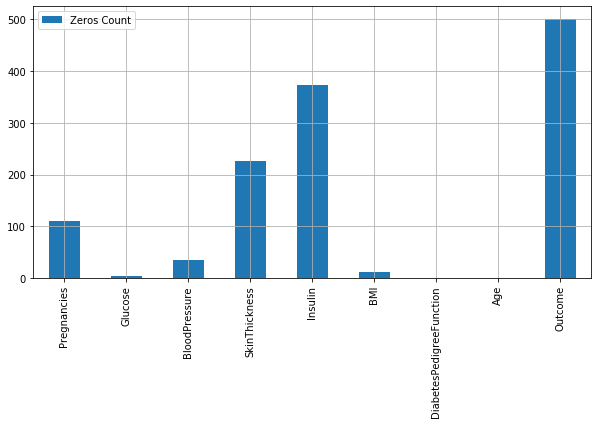

In [2]:
z=(df == 0).sum(axis=0)
z=pd.DataFrame(z)
z.columns=['Zeros Count']
# z.drop(' Class variable',inplace=True)
z.plot(kind='bar',stacked=True, figsize=(10,5),grid=True)

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
col=['pregnancy_count','glucose_conc','bp','skin_len','insulin','bmi','pedigree_fun','age','target']
df.columns=col
df.head()

,pregnancy_count,glucose_conc,bp,skin_len,insulin,bmi,pedigree_fun,age,target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.describe()

,pregnancy_count,glucose_conc,bp,skin_len,insulin,bmi,pedigree_fun,age,target
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
df[['glucose_conc','bp','skin_len','insulin','bmi']] = df[['glucose_conc','bp','skin_len','insulin','bmi']].replace(0,np.NaN)

In [7]:
df.isnull().sum()

pregnancy_count      0
glucose_conc         5
bp                  35
skin_len           227
insulin            374
bmi                 11
pedigree_fun         0
age                  0
target               0
dtype: int64

In [8]:
#function to retrive the median of the column and return the value of 0th index 
def get_median_at_0(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'target']].groupby(['target'])[[var]].median().reset_index()
    return temp.loc[0, var]

In [9]:
#function to retrive the median of the column and return the value of 1st index 
def get_median_at_1(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'target']].groupby(['target'])[[var]].median().reset_index()
    return temp.loc[1, var]

In [10]:
#function to replace the NaN values with appropriate median values
def replace_nan_with_median(var):
    df.loc[(df['target'] == 0) & (df[var].isnull()), var] = get_median_at_0(var)
    df.loc[(df['target'] == 1) & (df[var].isnull()), var] = get_median_at_1(var)
    return 0

In [11]:
replace_nan_with_median('glucose_conc')
replace_nan_with_median('bp')
replace_nan_with_median('insulin')
replace_nan_with_median('skin_len')
replace_nan_with_median('bmi')

0

In [12]:
df.head()

,pregnancy_count,glucose_conc,bp,skin_len,insulin,bmi,pedigree_fun,age,target
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [13]:
df.isnull().sum()

pregnancy_count    0
glucose_conc       0
bp                 0
skin_len           0
insulin            0
bmi                0
pedigree_fun       0
age                0
target             0
dtype: int64

In [14]:
df['pregnancy_count'].value_counts()

1     135
0     111
2     103
3      75
4      68
5      57
6      50
7      45
8      38
9      28
10     24
11     11
13     10
12      9
14      2
15      1
17      1
Name: pregnancy_count, dtype: int64

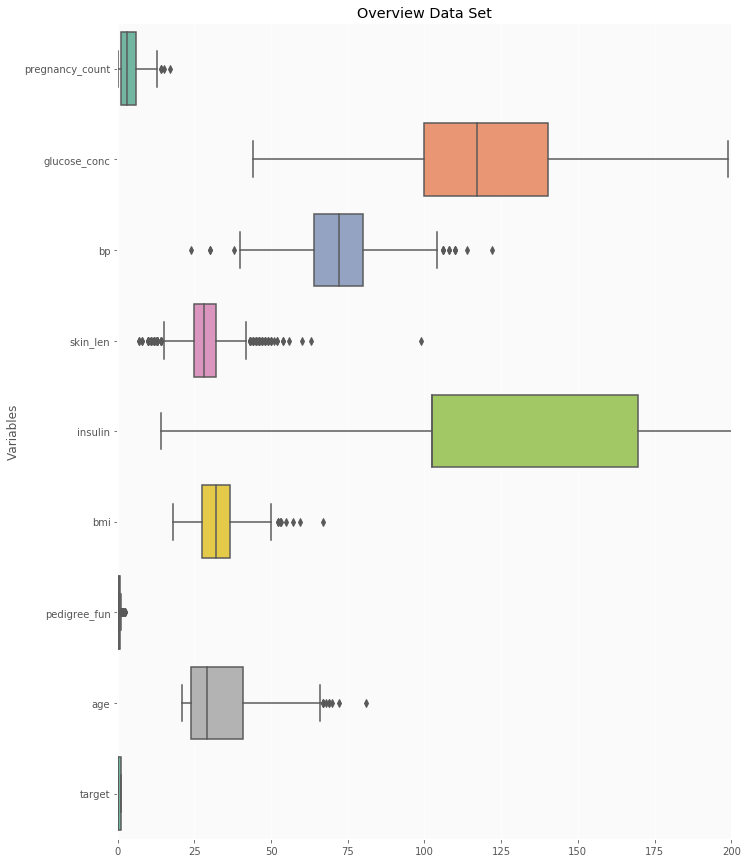

In [15]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = df, 
  orient = 'h', 
  palette = 'Set2')

In [16]:
#function to reduce outliers
def minimize_outliers_upper(var, limit):
    df.loc[(df['target'] == 0 ) & (df[var]>limit), var] = get_median_at_0(var)
    df.loc[(df['target'] == 1 ) & (df[var]>limit), var] = get_median_at_1(var)

In [17]:
#function to reduce outliers
def minimize_outliers_lower(var, limit):
    df.loc[(df['target'] == 0 ) & (df[var]<limit), var] = get_median_at_0(var)
    df.loc[(df['target'] == 1 ) & (df[var]<limit), var] = get_median_at_1(var)

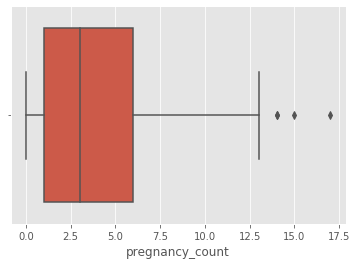

In [18]:
sns.boxplot(df.pregnancy_count)

In [19]:
minimize_outliers_upper('pregnancy_count', 13)

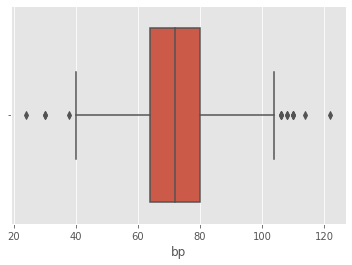

In [20]:
sns.boxplot(df.bp)

In [21]:
minimize_outliers_upper('bp', 105)
minimize_outliers_lower('bp', 40)

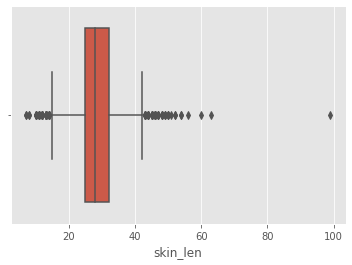

In [22]:
sns.boxplot(df.skin_len)

In [23]:
minimize_outliers_upper('skin_len', 38)
minimize_outliers_lower('skin_len', 20)

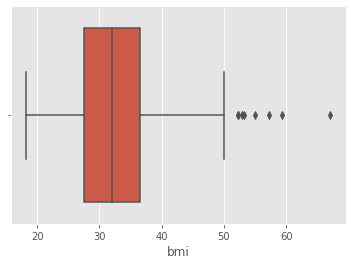

In [24]:
sns.boxplot(df.bmi)

In [25]:
minimize_outliers_upper('bmi', 47)

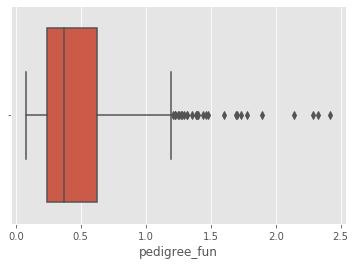

In [26]:
sns.boxplot(df.pedigree_fun)

In [27]:
minimize_outliers_upper('pedigree_fun', 1)

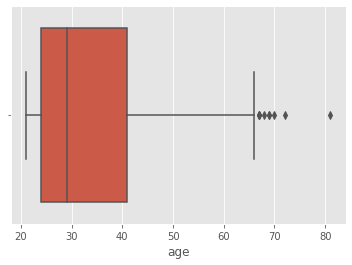

In [28]:
sns.boxplot(df.age)

In [29]:
minimize_outliers_upper('age', 61)

In [30]:
X = df.drop(['target'], 1)
y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)

In [31]:
#adding standard scaler to the data set
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [32]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.82421875

In [33]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

0.8828125

In [34]:
# clf = RandomForestClassifier()

# parameters = {
#     'n_estimators': [4, 6, 9], 
#     'max_features': ['log2', 'sqrt','auto'], 
#     'criterion': ['entropy', 'gini'],
#     'max_depth': [2, 3, 5, 10], 
#     'min_samples_split': [2, 3, 5],
#     'min_samples_leaf': [1,5,8]
# }

# parameters = {
#     'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
#     'max_features': ['log2', 'sqrt'], 
#     'criterion': ['entropy', 'gini'],
#     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
#     'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
#     'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10]
# }

# acc_scorer = make_scorer(accuracy_score)

# # Run the grid search
# grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
# grid_obj = grid_obj.fit(X_train, y_train)

# # Set the clf to the best combination of parameters
# clf = grid_obj.best_estimator_

# # Fit the best algorithm to the data. 
# clf.fit(X_train, y_train)

# print(grid_obj.best_params_)
# # Best score for Random Forest with best parameters
# print('Best score for Random Forest: {:.2f}%'.format(grid_obj.best_score_ * 100))

# best_params = grid_obj.best_params_

In [35]:
random_forest = RandomForestClassifier(
    n_estimators = 9,
    max_features= 'log2', 
    criterion= 'entropy',
    max_depth= 20, 
    min_samples_split= 9,
    min_samples_leaf= 3
)

random_forest.fit(X_train, y_train)
random_forest_predict = random_forest.predict(X_test)
random_forest_predict_proba = random_forest.predict_proba(X_test)[:, 1]

print('RandomForest Accuracy: {:.2f}%'.format(accuracy_score(y_test, random_forest_predict) * 100))
print('RandomForest AUC: {:.2f}%'.format(roc_auc_score(y_test, random_forest_predict_proba) * 100))
print('RandomForest Classification report:\n\n', classification_report(y_test, random_forest_predict))
print('RandomForest Training set score: {:.2f}%'.format(random_forest.score(X_train, y_train) * 100))
print('RandomForest Testing set score: {:.2f}%'.format(random_forest.score(X_test, y_test) * 100))

RandomForest Accuracy: 90.62%
RandomForest AUC: 94.36%
RandomForest Classification report:

               precision    recall  f1-score   support

           0       0.91      0.95      0.93       167
           1       0.89      0.83      0.86        89

    accuracy                           0.91       256
   macro avg       0.90      0.89      0.89       256
weighted avg       0.91      0.91      0.91       256

RandomForest Training set score: 95.51%
RandomForest Testing set score: 90.62%


In [36]:
pickle.dump(random_forest,open('model.pkl','wb'))